In [25]:
import math
import numpy as np
import ot
import matplotlib.pylab as pl
import ot.plot
import scipy
import torch
from scipy.sparse import csr_matrix


import os
from pathlib import Path
import time

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
torch.CUDA_LAUNCH_BLOCKING=1

print('Used device: '+device)

Used device: cpu


The document is as follow :

In [27]:
rng = np.random.RandomState(42)


def im2mat(img):
    """Converts an image to matrix (one pixel per line)"""
    return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))


def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)


def minmax(img):
    return np.clip(img, 0, 1)

In [41]:
def transform(Xs,xs,xt,P,batch_size=128): #xs xt training and Xs Xt all

    # perform out of sample mapping
    indices = np.arange(Xs.shape[0])
    batch_ind = [
        indices[i:i + batch_size]
        for i in range(0, len(indices), batch_size)]

    transp_Xs_l = []
    
    for bi in batch_ind:
        # get the nearest neighbor in the source domain
        D0 = ot.dist(Xs[bi], xs)
        idx = np.argmin(D0, axis=1)

        # transport the source samples
        transp = P/ np.sum(P, axis=1)[:, None]
        transp[~ np.isfinite(transp)] = 0
        transp_Xs = np.dot(transp, xt) #Barycentric Projection 

        # define the transported points
        transp_Xs = transp_Xs[idx, :] + Xs[bi] - xs[idx, :]
        transp_Xs_l.append(transp_Xs)

    transp_Xs_l = np.concatenate(transp_Xs_l, axis=0)

    return transp_Xs_l

def inverse_transform(Xt,xs,xt,P,batch_size=128): #xs xt training and Xs Xt all

    # perform out of sample mapping
    indices = np.arange(Xt.shape[0])
    batch_ind = [
        indices[i:i + batch_size]
        for i in range(0, len(indices), batch_size)]

    transp_Xt_l = []
    for bi in batch_ind:
        D0 = ot.dist(Xt[bi], xt)
        idx = np.argmin(D0, axis=1)

        # transport the target samples
        transp_ = P/ np.sum(P,0)[:, None]
        transp_[~ np.isfinite(transp_)] = 0
        transp_Xt = np.dot(transp_, xs)

        # define the transported points
        transp_Xt = transp_Xt[idx, :] + Xt[bi] - xt[idx, :]

        transp_Xt_l.append(transp_Xt)

    transp_Xt_l = np.concatenate(transp_Xt_l, axis=0)

    return transp_Xt_l

In [42]:
def compute_bary_line(X_line_sort,Y_line_sort,theta) :

    Z_line_sort=(X_line_sort+Y_line_sort)/2
    Z = Z_line_sort[:,None]*theta[None,:]
    
    return Z_line_sort,Z

def W2_line_W(X,X_line,X_line_sort,Y_line_sort,theta): # X distrib and Y on the line q
    
    n=X.shape[0]
    
    X_proj = X_line[:,None,:]*theta[None,:,:]
    if len(X.shape)==2:
        W_s = torch.norm(X[:,:,None]-X_proj,dim=(0,1))**2
    else :
        W_s = torch.norm(X-X_proj,dim=(0,1))**2
        
    W_1d = torch.sum((X_line_sort-Y_line_sort)**2,axis=0)

    return W_s/n+W_1d/n

def compute_bary_gene(X_sort,Y_sort):
    
    bary=(X_sort+Y_sort)/2

    return bary

def random_slice(n_proj,dim,device='cpu'):
    theta=torch.randn((n_proj,dim))
    theta=torch.stack([th/torch.sqrt((th**2).sum()) for th in theta])
    return theta.to(device)

def sort_to_plan(u,v):
    n=u.shape[0]
    temp=torch.arange(n)
    P1=torch.zeros((n,n))
    P2=torch.zeros((n,n))

    P1[u,temp]=1
    P2[v,temp]=1
    return (P1@P2.T)/n

In [43]:
def upperW2(X,Y,theta):
    n=X.shape[0]

    X_line=torch.matmul(X,theta)
    Y_line=torch.matmul(Y,theta)

    X_line_sort,u=torch.sort(X_line,axis=0)
    Y_line_sort,v=torch.sort(Y_line,axis=0)
   

    X_sort=X[u].transpose(1,2)
    Y_sort=Y[v].transpose(1,2)

    Z_line_sort,Z=compute_bary_line(X_line_sort,Y_line_sort,theta)
    
    bary=compute_bary_gene(X_sort,Y_sort)
    bary_line=torch.einsum('ijk,jk->ik',bary,theta)
        
    W_baryZ=W2_line_W(bary,bary_line,bary_line,Z_line_sort,theta)#W_s is zero in this situation
    W_XZ=W2_line_W(X,X_line,X_line_sort,Z_line_sort,theta)
    W_YZ=W2_line_W(Y,Y_line,Y_line_sort,Z_line_sort,theta)
    
    return -4*W_baryZ+2*W_XZ+2*W_YZ,u,v

/home/gui/Documents/Thèse/Approximation Wasserstein/Expe/Color Transfert/data/Images


Text(0.5, 1.0, 'Image 2')

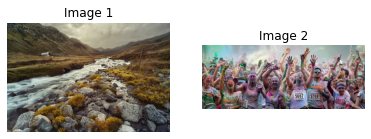

In [44]:
# Loading images
this_file = os.path.realpath('__file__')
data_path = os.path.join(Path(this_file).parent, 'data/Images')
#data_path = os.path.join(Path(this_file).parent)
print(data_path)
I1 = pl.imread(os.path.join(data_path, 'river.jpg')).astype(np.float64) / 256
I2 = pl.imread(os.path.join(data_path, 'run.jpg')).astype(np.float64) / 256

X1 = im2mat(I1)
X2 = im2mat(I2)

pl.figure(1, figsize=(6.4, 3))
pl.subplot(1, 2, 1)
pl.imshow(I1)
pl.axis('off')
pl.title('Image 1')

pl.subplot(1, 2, 2)
pl.imshow(I2)
pl.axis('off')
pl.title('Image 2')

In [45]:
I1.shape

(605, 900, 3)

In [46]:
rng = np.random.RandomState(42)

### Training Samples ###

def random_subsample(X1,X2,nb=200):
    idx1 = rng.randint(X1.shape[0], size=(nb,))
    idx2 = rng.randint(X2.shape[0], size=(nb,))
    xs = X1[idx1, :]
    xt = X2[idx2, :]
    return xs,xt

def kmean_subsample(X1,X2,nb=200):
    kmeans1 = KMeans(n_clusters=nb, random_state=0).fit(X1)
    kmeans2 = KMeans(n_clusters=nb, random_state=0).fit(X2)
    idx1=kmeans.labels_
    idx2=kmeans.labels_
    xs = X1[idx1, :]
    xt = X2[idx2, :]
    return xs,xt    

def minibatch_kmeans_subsample(X1,X2,nb=200,batch_size=5000,max_iter=300):
    kmeans = MiniBatchKMeans(n_clusters=nb,random_state=0,batch_size=batch_size,max_iter=max_iter).fit(X1)
    xs=kmeans.cluster_centers_
    kmeans = MiniBatchKMeans(n_clusters=nb,random_state=0,batch_size=batch_size,max_iter=max_iter).fit(X2)
    xt=kmeans.cluster_centers_
    return xs,xt

In [47]:
def exact_emd(xs,xt,batch_size=500):
    ## Exact Plan ##
    C=ot.dist(xs,xt)
    ns=np.shape(xs)[0]
    nt=np.shape(xt)[0]
    a, b = np.ones((ns,)), np.ones((nt,))

    P=ot.emd(a,b,C,numItermax=200000)

    transp_Xs=transform(X1,xs,xt,P,batch_size)
    I1_plan=minmax(mat2im(transp_Xs, I1.shape))

    transp_Xt=inverse_transform(X2,xs,xt,P.T,batch_size)
    I2_plan=minmax(mat2im(transp_Xt, I2.shape))
    return I1_plan,I2_plan

def plan_minS(xs,xt,n_proj=1000):
    n_proj=200
    theta=random_slice(n_proj,3)
    theta=theta.T
    xs_torch = torch.from_numpy(xs).to(device)
    xt_torch = torch.from_numpy(xt).to(device)

    xs_torch=xs_torch.float()
    xt_torch=xt_torch.float()

    W,u,v=upperW2(xs_torch,xt_torch,theta)
    i=torch.argmin(W)
    P=sort_to_plan(u[:,i],v[:,i])
    P=np.array(P)


    transp_Xs=transform(X1,xs,xt,P,batch_size)
    I1_minS=minmax(mat2im(transp_Xs, I1.shape))

    transp_Xt=inverse_transform(X2,xs,xt,P.T,batch_size)
    I2_minS=minmax(mat2im(transp_Xt, I2.shape))
    return I1_minS,I2_minS

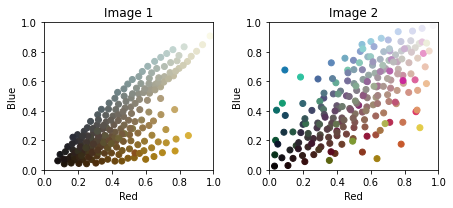

In [48]:

xs,xt=minibatch_kmeans_subsample(X1,X2,nb=200)

pl.figure(2, figsize=(6.4, 3))
pl.subplot(1, 2, 1)
pl.scatter(xs[:, 0], xs[:, 2], c=xs)
pl.axis([0, 1, 0, 1])
pl.xlabel('Red')
pl.ylabel('Blue')
pl.title('Image 1')

pl.subplot(1, 2, 2)
pl.scatter(xt[:, 0], xt[:, 2], c=xt)
pl.axis([0, 1, 0, 1])
pl.xlabel('Red')
pl.ylabel('Blue')
pl.title('Image 2')
pl.tight_layout()

batch_size=500
I1_plan,I2_plan=exact_emd(xs,xt,batch_size)
I1_minS,I2_minS=plan_minS(xs,xt,n_proj=1000)

In [49]:
xs.shape

(200, 3)

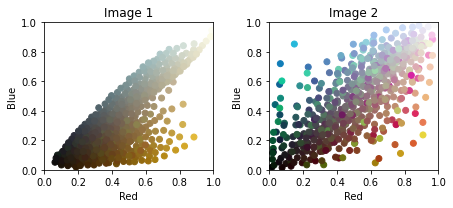

In [50]:

xs,xt=minibatch_kmeans_subsample(X1,X2,nb=500)

pl.figure(2, figsize=(6.4, 3))
pl.subplot(1, 2, 1)
pl.scatter(xs[:, 0], xs[:, 2], c=xs)
pl.axis([0, 1, 0, 1])
pl.xlabel('Red')
pl.ylabel('Blue')
pl.title('Image 1')

pl.subplot(1, 2, 2)
pl.scatter(xt[:, 0], xt[:, 2], c=xt)
pl.axis([0, 1, 0, 1])
pl.xlabel('Red')
pl.ylabel('Blue')
pl.title('Image 2')
pl.tight_layout()

I1_minS_500,I2_minS_500=plan_minS(xs,xt)

In [51]:
I1_minS_500.shape

(605, 900, 3)

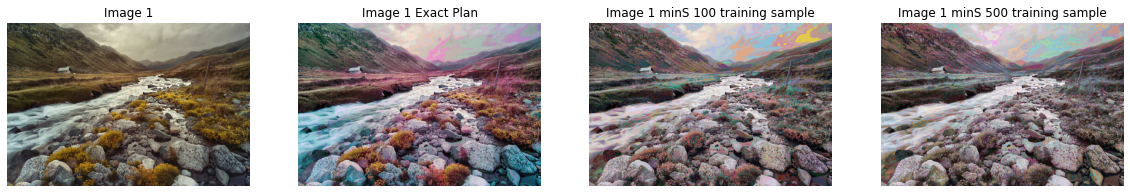

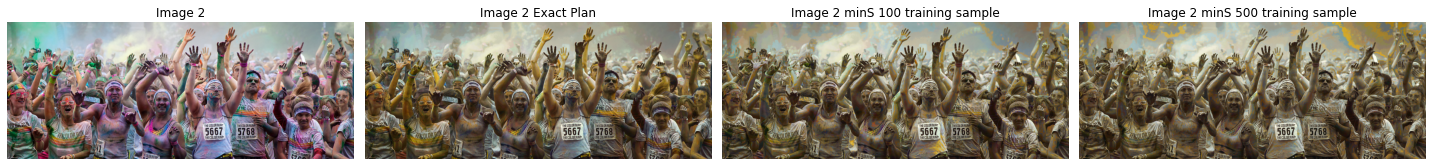

In [52]:
pl.figure(figsize=(20, 100))

pl.plot([1,4,4])
pl.subplot(2, 4, 1)
pl.imshow(I1)
pl.axis('off')
pl.title('Image 1')

pl.subplot(2, 4, 2)
pl.imshow(I1_plan)
pl.axis('off')
pl.title('Image 1 Exact Plan')

pl.subplot(2, 4, 3)
pl.imshow(I1_minS)
pl.axis('off')
pl.title('Image 1 minS 100 training sample')

pl.subplot(2, 4, 4)
pl.imshow(I1_minS_500)
pl.axis('off')
pl.title('Image 1 minS 500 training sample')
pl.show()


pl.figure(figsize=(20, 10))
pl.plot([1,4,4])

pl.subplot(2, 4, 5)
pl.imshow(I2)
pl.axis('off')
pl.title('Image 2')

pl.subplot(2, 4, 6)
pl.imshow(I2_plan)
pl.axis('off')
pl.title('Image 2 Exact Plan')

pl.subplot(2, 4, 7)
pl.imshow(I2_minS)
pl.axis('off')
pl.title('Image 2 minS 100 training sample')
pl.tight_layout()

pl.subplot(2, 4, 8)
pl.imshow(I2_minS_500)
pl.axis('off')
pl.title('Image 2 minS 500 training sample')
pl.tight_layout()
pl.show()